In [1]:
from glob import glob
import cv2
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
from skimage.morphology import label
from tqdm import tqdm_notebook
from skimage.morphology import binary_opening, disk, label

import torch.nn as nn
import torch

from fastai.conv_learner import *
from fastai.dataset import *


%matplotlib notebook
%reload_ext autoreload
%autoreload 2

In [2]:
torch.cuda.set_device(0)
torch.cuda.is_available()

True

In [3]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))
    
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()
            
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [4]:
f = resnet34
cut,lr_cut = model_meta[f]

def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [5]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [6]:
df = pd.read_csv(os.path.join('data', 'train_ship_segmentations.csv'))
TRAIN_DR = 'data/train'
# TRAIN_LABEL_DN = 'data/train_mask'
# x_names = np.array(glob(str(Path(TRAIN_DN)/f'*.jpg')))[:10000]
# y_names = np.array(glob(str(Path(TRAIN_LABEL_DN)/f'*.jpg')))[:10000]

# val_idxs = list(range(500))
# ((val_x, trn_x), (val_y, trn_y)) = split_by_idx(val_idxs, x_names, y_names)

val_df = df[:1000]
train_df = df[1000:30000]

In [7]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.float32)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return all_masks

In [8]:
def dataloader(dataframe, bs):
    batch_image_arr = []
    batch_label_arr = []
    cnt = 0
    
    all_batches = list(dataframe.groupby('ImageId'))
    for c_img_id, c_masks in all_batches:
        mask_arr = masks_as_image(c_masks['EncodedPixels'].values)
        image_arr = open_image(os.path.join(TRAIN_DR, c_img_id))
        image_arr = image_arr * 2 - 1
        batch_image_arr.append(image_arr.T)
        batch_label_arr.append(mask_arr.T)
        cnt += 1
        if cnt >= bs:
            cnt = 0
            yield np.array(batch_image_arr), np.array(batch_label_arr)
            batch_image_arr, batch_label_arr = [], []
    if len(batch_image_arr) and len(batch_label_arr):
        yield np.array(batch_image_arr), np.array(batch_label_arr)

1.0


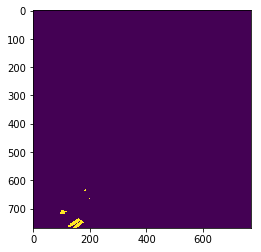

In [20]:
def find_image(image_name, dataframe):
    all_batches = list(dataframe.groupby('ImageId'))
    for c_img_id, c_masks in all_batches:
        if c_img_id == image_name:
            mask_arr = masks_as_image(c_masks['EncodedPixels'].values)
            image_arr = open_image(os.path.join(TRAIN_DR, c_img_id))
            break
    plt.imshow(mask_arr[:,:])

find_image('00021ddc3.jpg', df)

In [9]:
def train(model, loss_fn, optimizer, trn_df, val_df, num_epochs = 1):
    for epoch in range(num_epochs):
        model.train()
        train_loss = []
        pbar = tqdm(total=int(len(trn_df)/6)+int(len(val_df)/3))
        trainloader = dataloader(trn_df, bs=6)
        valloader = dataloader(val_df, bs=3)
        for x, y in trainloader:
            x = Variable(torch.from_numpy(x).cuda())
            y = Variable(torch.from_numpy(y).cuda())
            optimizer.zero_grad()
            scores = model(x)
            loss = loss_fn(scores, y)
            train_loss.append(loss.data[0])
            loss.backward()
            optimizer.step()
            pbar.set_description('train loss = {0:.5f}, val loss = nan'.format(loss.data[0]))
            pbar.update(1)
        train_mean_loss = np.mean(train_loss)
        gc.collect()
        
        val_loss = []
        for t, (x, y) in enumerate(valloader):
            x = Variable(torch.from_numpy(x).cuda())
            y = Variable(torch.from_numpy(y).cuda())
            scores = model(x)
            loss = loss_fn(scores, y)
            val_loss.append(loss.data[0])
            pbar.set_description('train loss = {0:.5f}, val loss = {1:.5f}'.format(train_mean_loss, np.mean(val_loss)))
            pbar.update(1)
        pbar.close()
        del x, y, scores, loss
        gc.collect()

def check_accuracy(model, loader):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.cuda())

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.5f)' % (num_correct, num_samples, 100 * acc))

In [10]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * ((pred*targs).sum()+1e-8)/ ((pred+targs).sum()+1e-8)

In [11]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(m.parameters(), lr=1e-2)

In [12]:
train(m, loss_fn, optimizer, train_df, val_df, num_epochs=10)

train loss = 0.00206, val loss = 0.00210:  80%|███████▉  | 4129/5166 [28:32<07:10,  2.41it/s]


In [13]:
test_paths = './data/test/'
out_pred_rows = []
for c_path in tqdm_notebook(glob(os.path.join(test_paths, '*.jpg'))):
    c_img = open_image(c_path)
    c_img = c_img * 2 - 1
    c_img = c_img.T
    c_img = np.expand_dims(c_img, 0)
    cur_seg = m(Variable(torch.from_numpy(c_img).cuda()))
    cur_seg = cur_seg.cpu().data.numpy()
    cur_seg = np.expand_dims(cur_seg[0, :, :].T, axis=0)
    cur_seg = binary_opening(cur_seg>0, np.expand_dims(disk(2), -1))
    cur_rles = multi_rle_encode(cur_seg)
    if len(cur_rles)>0:
        for c_rle in cur_rles:
            out_pred_rows += [{'ImageId': os.path.basename(c_path), 'EncodedPixels': c_rle}]
    else:
        out_pred_rows += [{'ImageId': os.path.basename(c_path), 'EncodedPixels': None}]
    gc.collect()

In [14]:
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]

In [15]:
submission_df.head()

,ImageId,EncodedPixels
0,c26e42455.jpg,None
1,af0d4aa65.jpg,None
2,f2a4ea559.jpg,None
3,4be39ce24.jpg,None
4,01d83dd8a.jpg,None


In [16]:
submission_df.to_csv('submission.csv', index=False)

In [43]:
c_path

'./data/test/e42e01752.jpg'

In [22]:
c_img.shape

(1, 3, 768, 768)

In [25]:
cur_seg = m(Variable(torch.from_numpy(c_img).cuda()))

In [32]:
cur_seg.cpu().data.numpy().shape

(1, 768, 768)

In [35]:
cur_seg.shape

(768, 768)

In [24]:
cv2.imread('data/dba4b574c.jpg', cv2.IMREAD_UNCHANGED).max()

2

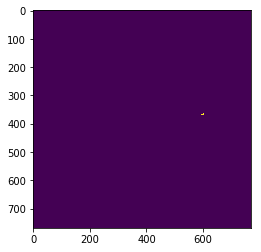

In [25]:
plt.imshow(cv2.imread('data/dba4b574c.jpg', cv2.IMREAD_UNCHANGED)*255)

In [26]:
cv2.imread('data/dba4b574c.jpg', cv2.IMREAD_UNCHANGED).max()

2

In [29]:
np.where(cv2.imread('data/dba4b574c.jpg', cv2.IMREAD_UNCHANGED) == 2)

(array([367, 367]), array([598, 599]))

In [30]:
np.where(cv2.imread('data/dba4b574c.jpg', cv2.IMREAD_UNCHANGED) == 1)

(array([363, 363, 364, 364, 365, 365, 365, 365, 366, 366, 366, 366, 366, 366, 366, 366, 366, 367, 367, 367,
        367, 367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 369, 369,
        369, 369, 369, 369, 369, 369, 370, 370, 370, 370]),
 array([600, 601, 600, 601, 598, 599, 600, 601, 594, 595, 596, 597, 598, 599, 600, 601, 602, 592, 593, 594,
        595, 596, 597, 600, 601, 602, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 593, 594,
        595, 596, 597, 598, 600, 601, 594, 595, 596, 597]))